### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('')  # Fill this row with the path of the training dataset

print(dataset.shape)
dataset.head(10)

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672
5,7.82592,4.22372,10.11672,1.64906,3.12314,47.010218,3.41862
6,7.52214,4.11250,9.89428,1.58930,3.22440,46.892360,3.24100
7,7.31962,4.00128,9.56062,1.53120,3.12314,45.959439,3.24100
8,7.26982,3.89006,9.56062,1.58930,3.02188,47.126421,3.12314
9,7.26982,4.00128,9.56062,1.70716,2.97208,46.659961,3.24100


In [ ]:
# Let's check if there are null values, and if the data type coincides with float32, as required.
dataset.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


The dataset does not contain null values, but the Dtype has to be changed. 

In [ ]:
# Convert Dtype into float32
dataset = dataset.astype({"Sponginess":'float32', "Wonder level":'float32', "Crunchiness":'float32', "Loudness on impact":'float32', "Meme creativity":'float32', "Soap slipperiness":'float32', "Hype root":'float32'})
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float32
 1   Wonder level        68528 non-null  float32
 2   Crunchiness         68528 non-null  float32
 3   Loudness on impact  68528 non-null  float32
 4   Meme creativity     68528 non-null  float32
 5   Soap slipperiness   68528 non-null  float32
 6   Hype root           68528 non-null  float32
dtypes: float32(7)
memory usage: 1.8 MB


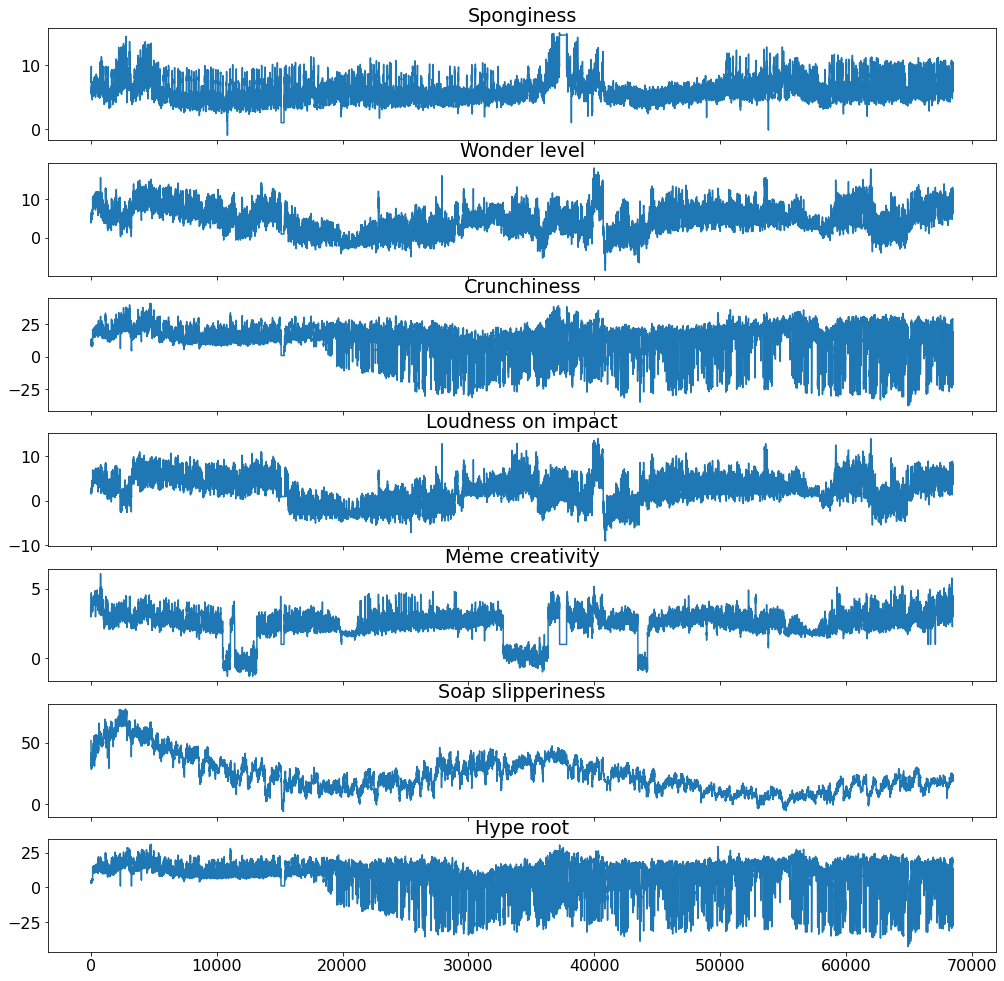

In [ ]:
# This function is created in order to inspect the dataframe
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

### Train-Test Split

In [ ]:
# The best estimator for the future is the last part of the datasest: thus, this is what we will use as test set (paying attention to avoiding shuffling in order to 
# avoid destroying information)
test_size =5945                           
X_train_raw = dataset.iloc[:-test_size] 
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)


(62583, 7) (5945, 7)


In [ ]:
# Compute max and min on the train 
X_min = X_train_raw.min()
X_max = X_train_raw.max()

# Normalize both train and test
X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)


In [ ]:
# This function is used in order to create the sequences: starting from the original (long) timeseries, it divides it into small subsequences of a predefined length (window
# size) based on the ‘stride’ parameter which defines the number of steps between two following subsequences. 
# The parameter ‘telescope' indicates how much far away the model will look in the future in terms of points
def build_sequences(df, target_labels, window, stride, telescope):
   
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32') #float32
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32') #float32
        temp_label = np.concatenate((padding,temp_label))  #the padding will be added in the HEAD of the time series 
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
# At this point, we define some of the hyperparameters: window, stride and telescope. These values were chosen after trying many different combinations. 
window = 300    
stride =  10   
telescope = 24  

In [ ]:
# Let's apply the build_sequences function
target_labels = dataset.columns

X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6238, 300, 7), (6238, 24, 7), (568, 300, 7), (568, 24, 7))

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

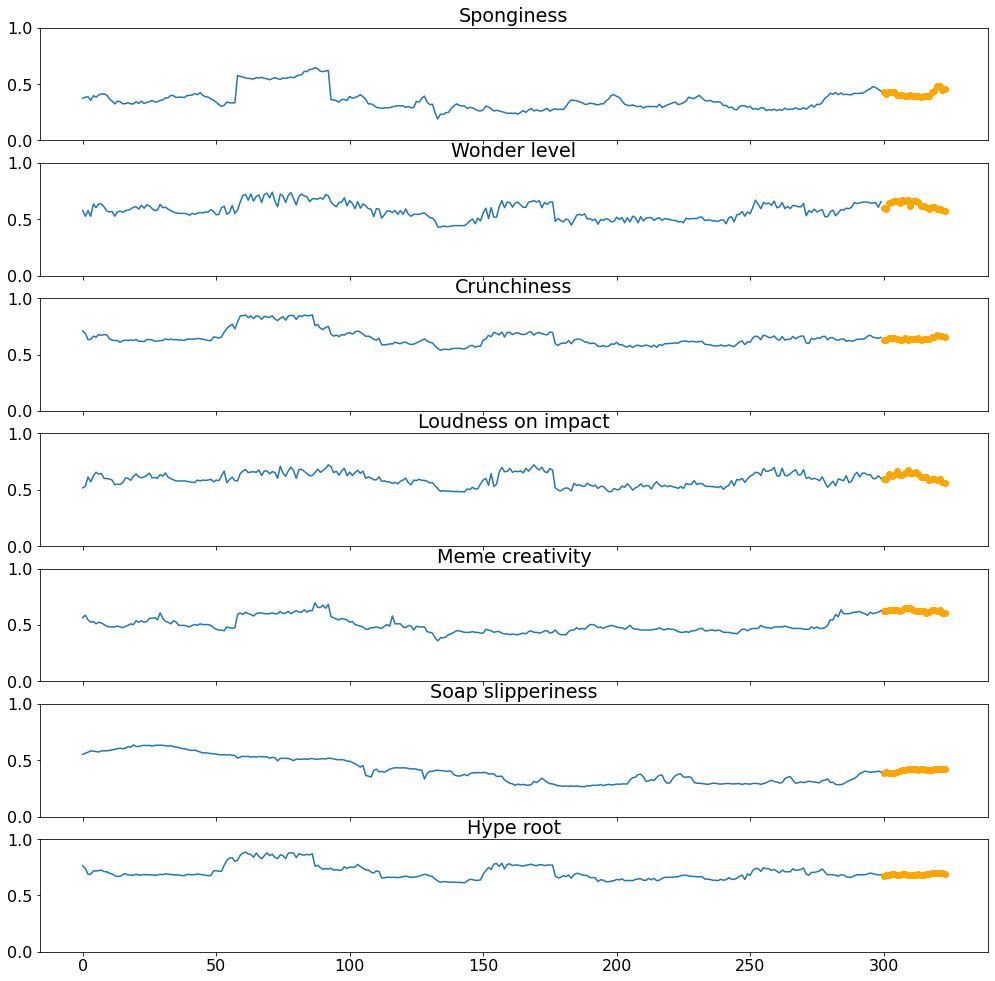

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 128
epochs = 200

## Model Definition

In [ ]:
# We define this function in order to implement attention inside our model

def attention_3d_block(inputs):
    input_dim = int(inputs.shape[2])
    a = inputs
    a = tfkl.Dense(input_dim, activation='softmax')(a)
    a_probs = tfkl.Permute((1, 2), name='attention_vec')(a)
    output_attention_mul = tfkl.Multiply()([inputs, a_probs])
    return output_attention_mul

In [ ]:
# This is the model, which is a Convolutional LSTM with an attention layer 
def attention_model(input_shape, output_shape):
    inputs = tfkl.Input(shape=input_shape)

    x = tfkl.Conv1D(filters = 128, kernel_size = 1, activation = 'relu')(inputs)  
    x = tfkl.Dropout(0.3)(x)

    lstm_out = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(x)
    lstm_out = tfkl.Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = tfkl.Flatten()(attention_mul)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(attention_mul)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    model = tfk.Model(inputs=[inputs], outputs=output_layer)

    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
    
    return model

In [ ]:
model = attention_model(input_shape, output_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 7)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 300, 128)     1024        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 300, 128)     0           ['conv1d[0][0]']                 
                                                                                                  
 bidirectional (Bidirectional)  (None, 300, 512)     788480      ['dropout[0][0]']                
                                                                                              

### Model training

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

2022-01-15 09:33:31.679179: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/200
44/44 [==============================] - 147s 3s/step - loss: 0.0619 - mae: 0.1791 - val_loss: 0.0215 - val_mae: 0.1094 - lr: 0.0010
Epoch 2/200
44/44 [==============================] - 145s 3s/step - loss: 0.0201 - mae: 0.1059 - val_loss: 0.0231 - val_mae: 0.1109 - lr: 0.0010
Epoch 3/200
44/44 [==============================] - 133s 3s/step - loss: 0.0168 - mae: 0.0968 - val_loss: 0.0189 - val_mae: 0.0957 - lr: 0.0010
Epoch 4/200
44/44 [==============================] - 122s 3s/step - loss: 0.0140 - mae: 0.0883 - val_loss: 0.0144 - val_mae: 0.0879 - lr: 0.0010
Epoch 5/200
44/44 [==============================] - 124s 3s/step - loss: 0.0117 - mae: 0.0826 - val_loss: 0.0138 - val_mae: 0.0869 - lr: 0.0010
Epoch 6/200
44/44 [==============================] - 124s 3s/step - loss: 0.0093 - mae: 0.0729 - val_loss: 0.0115 - val_mae: 0.0788 - lr: 0.0010
Epoch 7/200
44/44 [==============================] - 123s 3s/step - loss: 0.0069 - mae: 0.0607 - val_loss: 0.0086 - val_mae: 0.063

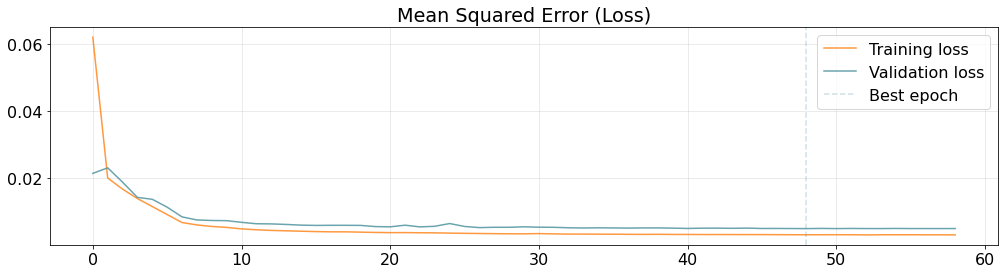

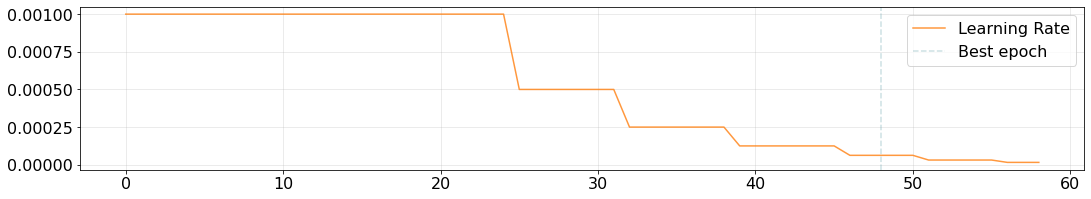

In [ ]:
# Plot the behaviour of the model and of the learning rate
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()


plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Save the Model
model.save('ConvLSTM_attention')

2022-01-15 12:10:29.440017: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### Model Re-training on the entire dataset
In order to have a better model, we retrained it on the whole dataset, without holding out data for testing or validation. To do this, we used as learning rate and number of epochs the values of the previous training.


In [ ]:
# Load the model
model= tfk.models.load_model('ConvLSTM_attention')

In [ ]:
# Concatenate train and test 
X= np.concatenate((X_train, X_test))
y= np.concatenate((y_train, y_test))
X.shape, y.shape 

((6806, 300, 7), (6806, 24, 7))

In [ ]:
model.optimizer.learning_rate=  1.5625e-05 # learning rate

# Train the model 
model.fit(x=X, 
          y=y,
          batch_size= batch_size, 
          epochs= 59)

Epoch 1/59
54/54 [==============================] - 150s 3s/step - loss: 0.0036 - mae: 0.0423
Epoch 2/59
54/54 [==============================] - 148s 3s/step - loss: 0.0036 - mae: 0.0422
Epoch 3/59
54/54 [==============================] - 1376s 26s/step - loss: 0.0036 - mae: 0.0423
Epoch 4/59
54/54 [==============================] - 181s 3s/step - loss: 0.0036 - mae: 0.0423
Epoch 5/59
54/54 [==============================] - 173s 3s/step - loss: 0.0036 - mae: 0.0421
Epoch 6/59
54/54 [==============================] - 145s 3s/step - loss: 0.0036 - mae: 0.0424
Epoch 7/59
54/54 [==============================] - 151s 3s/step - loss: 0.0036 - mae: 0.0421
Epoch 8/59
54/54 [==============================] - 179s 3s/step - loss: 0.0036 - mae: 0.0421
Epoch 9/59
54/54 [==============================] - 181s 3s/step - loss: 0.0036 - mae: 0.0423
Epoch 10/59
54/54 [==============================] - 180s 3s/step - loss: 0.0036 - mae: 0.0422
Epoch 11/59
54/54 [==============================] - 181s

In [ ]:
# Save the model
model.save('ConvLSTM_attention_final')